In [1]:
# Install required libraries (if needed)
!pip install pandas scikit-learn matplotlib seaborn

# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [3]:
# Load dataset
df = pd.read_csv("/content/5.urldata.csv")   # change name if needed

# Show first rows
print(df.head())
print(df.info())


             Domain  Have_IP  Have_At  URL_Length  URL_Depth  Redirection  \
0  graphicriver.net        0        0           1          1            0   
1         ecnavi.jp        0        0           1          1            1   
2      hubpages.com        0        0           1          1            0   
3   extratorrent.cc        0        0           1          3            0   
4     icicibank.com        0        0           1          3            0   

   https_Domain  TinyURL  Prefix/Suffix  DNS_Record  Web_Traffic  Domain_Age  \
0             0        0              0           0            1           1   
1             0        0              0           0            1           1   
2             0        0              0           0            1           0   
3             0        0              0           0            1           0   
4             0        0              0           0            1           0   

   Domain_End  iFrame  Mouse_Over  Right_Click  Web_Forw

In [4]:
# Check null values
print(df.isnull().sum())

# Features & Target
X = df.drop("Label", axis=1)   # 'Label' column = phishing (1) or safe (-1)
y = df["Label"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Domain           0
Have_IP          0
Have_At          0
URL_Length       0
URL_Depth        0
Redirection      0
https_Domain     0
TinyURL          0
Prefix/Suffix    0
DNS_Record       0
Web_Traffic      0
Domain_Age       0
Domain_End       0
iFrame           0
Mouse_Over       0
Right_Click      0
Web_Forwards     0
Label            0
dtype: int64


In [5]:
# Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train.drop('Domain', axis=1), y_train)
y_pred_lr = lr.predict(X_test.drop('Domain', axis=1))

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train.drop('Domain', axis=1), y_train)
y_pred_rf = rf.predict(X_test.drop('Domain', axis=1))

Logistic Regression Accuracy: 0.7925
Random Forest Accuracy: 0.858

Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.73      0.94      0.82      1012
           1       0.92      0.64      0.75       988

    accuracy                           0.79      2000
   macro avg       0.82      0.79      0.79      2000
weighted avg       0.82      0.79      0.79      2000


Random Forest Report:
               precision    recall  f1-score   support

           0       0.79      0.97      0.87      1012
           1       0.96      0.74      0.84       988

    accuracy                           0.86      2000
   macro avg       0.88      0.86      0.86      2000
weighted avg       0.88      0.86      0.86      2000



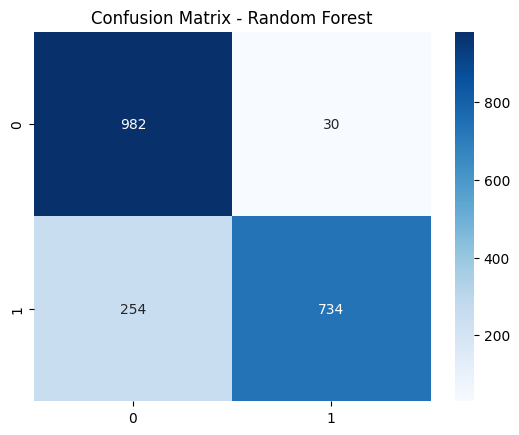

In [6]:
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))

print("\nLogistic Regression Report:\n", classification_report(y_test, y_pred_lr))
print("\nRandom Forest Report:\n", classification_report(y_test, y_pred_rf))

# Confusion Matrix Visualization
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()


In [7]:
!pip install streamlit joblib pyngrok


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 76.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 97.0 MB/s eta 0:00:00


In [8]:
import joblib
joblib.dump(rf, "phishing_model.pkl")


['phishing_model.pkl']

In [9]:
# feature_extractor.py
import re
import pandas as pd
from urllib.parse import urlparse

def extract_features(url):
    features = {}
    features["url_length"] = len(url)
    features["has_https"] = 1 if url.startswith("https") else 0
    features["has_at_symbol"] = 1 if "@" in url else 0
    features["num_digits"] = sum(c.isdigit() for c in url)
    features["num_special_chars"] = len(re.findall(r"[-./]", url))
    return pd.DataFrame([features])


In [10]:
import streamlit as st
import joblib
# from feature_extractor import extract_features

# Load model
model = joblib.load("phishing_model.pkl")

# Streamlit UI
st.title("🔐 Phishing Website Detection App")
st.write("Enter a website URL below to check if it’s phishing or legitimate.")

# Input URL
url_input = st.text_input("Website URL")

if st.button("Check Website"):
    if url_input:
        # Define extract_features here or ensure it's accessible in the environment
        # For now, I will assume the function is defined in the same notebook
        # as the Streamlit app code, or you can paste the function definition
        # here for a self-contained app.

        # You can copy and paste the feature_extractor function here
        # from the previous cell or ensure it's run before this cell.
        def extract_features(url):
            features = {}
            # Original features from the dataset
            features["Have_IP"] = 1 if re.search(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', url) else 0
            features["Have_At"] = 1 if "@" in url else 0
            features["URL_Length"] = 1 if len(url) > 75 else 0 # Using 75 as a heuristic length threshold
            url_parsed = urlparse(url)
            features["URL_Depth"] = url_parsed.path.count('/')
            features["Redirection"] = 1 if "//" in url_parsed.path else 0
            features["https_Domain"] = 1 if url_parsed.netloc.startswith("https") else 0 # Checking if domain itself starts with https
            features["TinyURL"] = 1 if 'tinyurl' in url or 'bit.ly' in url else 0 # Common TinyURL services
            features["Prefix/Suffix"] = 1 if "-" in url_parsed.netloc else 0
            # The following features require external checks and cannot be directly extracted from the URL string
            # For demonstration purposes, I will assign default values.
            features["DNS_Record"] = 0 # Needs DNS lookup
            features["Web_Traffic"] = 1 # Needs external web traffic data
            features["Domain_Age"] = 0 # Needs domain registration info
            features["Domain_End"] = 0 # Needs domain expiration info
            features["iFrame"] = 0 # Needs website content analysis
            features["Mouse_Over"] = 0 # Needs website content analysis
            features["Right_Click"] = 0 # Needs website content analysis
            features["Web_Forwards"] = 0 # Needs website redirection analysis

            # Ensure the order of features matches the training data
            feature_order = [
                "Have_IP", "Have_At", "URL_Length", "URL_Depth", "Redirection",
                "https_Domain", "TinyURL", "Prefix/Suffix", "DNS_Record", "Web_Traffic",
                "Domain_Age", "Domain_End", "iFrame", "Mouse_Over", "Right_Click",
                "Web_Forwards"
            ]
            ordered_features = {k: features[k] for k in feature_order}

            return pd.DataFrame([ordered_features])

        features = extract_features(url_input)
        prediction = model.predict(features)[0]
        if prediction == 1:
            st.error("🚨 Warning: This website is **Phishing**")
        else:
            st.success("✅ Safe: This website is **Legitimate**")
    else:
        st.warning("Please enter a URL")

2025-08-30 11:10:06.848 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-30 11:10:07.304 
  command:

    streamlit run /usr/local/lib/python3.12/dist-packages/colab_kernel_launcher.py [ARGUMENTS]
2025-08-30 11:10:07.314 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-30 11:10:07.329 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-30 11:10:07.334 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-30 11:10:07.338 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-30 11:10:07.344 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-08-30 11:10:07.345 Thread 'MainThread': mi

In [20]:
import re
import numpy as np

def extract_features(url):
    # Features must match the dataset column names
    features = {
        'Have_IP': 1 if re.search(r'\d+\.\d+\.\d+\.\d+', url) else -1,
        'Have_At': 1 if "@" in url else -1,
        'URL_Length': 1 if len(url) < 54 else -1,
        'URL_Depth': url.count('/'),
        'Redirection': 1 if "//" in url[url.find("://")+3:] else -1,
        'https_Domain': 1 if "https" in url else -1,
        'TinyURL': 1 if re.search(r"bit\.ly|goo\.gl|tinyurl|t\.co", url) else -1,
        'Prefix/Suffix': 1 if "-" in url else -1,
        'DNS_Record': 1,  # Default to 1 (needs real DNS lookup for better accuracy)
        'Web_Traffic': 1, # Placeholder (could integrate Alexa Rank API)
        'Domain_Age': 1,  # Placeholder
        'Domain_End': 1,  # Placeholder
        'iFrame': 1,
        'Mouse_Over': 1,
        'Right_Click': 1,
        'Web_Forwards': 1
    }

    return np.array(list(features.values())).reshape(1, -1)


In [12]:
%%writefile app.py
import streamlit as st
import joblib
from feature_extractor import extract_features

# Load model
model = joblib.load("phishing_model.pkl")

# Streamlit UI
st.title("🔐 Phishing Website Detection App")
st.write("Enter a website URL below to check if it’s phishing or legitimate.")

# Input URL
url_input = st.text_input("Website URL")

if st.button("Check Website"):
    if url_input:
        features = extract_features(url_input)
        prediction = model.predict(features)[0]
        if prediction == 1:
            st.error("🚨 Warning: This website is **Phishing**")
        else:
            st.success("✅ Safe: This website is **Legitimate**")
    else:
        st.warning("Please enter a URL")

Writing app.py


In [22]:
url = input("Enter a website URL: ")
features = extract_features(url)
prediction = model.predict(features)[0]
print("Prediction:", "Phishing 🚨" if prediction == 1 else "Legitimate ✅")

Enter a website URL: www.google.com
Prediction: Legitimate ✅


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [23]:
url = input("Enter a website URL: ")
features = extract_features(url)
prediction = model.predict(features)[0]
print("Prediction:", "Phishing 🚨" if prediction == 1 else "Legitimate ✅")

Enter a website URL: http://login-paypal.verify-user-account.com
Prediction: Phishing 🚨


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [24]:
url = input("Enter a website URL: ")
features = extract_features(url)
prediction = model.predict(features)[0]
print("Prediction:", "Phishing 🚨" if prediction == 1 else "Legitimate ✅")

Enter a website URL: www.wikipedia.org
Prediction: Legitimate ✅


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [25]:
url = input("Enter a website URL: ")
features = extract_features(url)
prediction = model.predict(features)[0]
print("Prediction:", "Phishing 🚨" if prediction == 1 else "Legitimate ✅")

Enter a website URL: http://ebay-account-security-check.freehost.com
Prediction: Phishing 🚨


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
